In [99]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import math
import numpy as np 
import seaborn as sns

class TSP():
    cities = 0
    distances = []
    locations = []
    
    def distance(self, c1, c2):
        loc1, loc2 = self.locations[c1], self.locations[c2]
        return math.sqrt((loc1[0]-loc2[0])**2 + (loc1[1]-loc2[1])**2)
    
    def __init__(self, cities, seed=1):
        random.seed(seed)
        self.cities = cities
        
        self.locations = []
        for i in range(cities):
            self.locations.append((random.random(), random.random()))
        
        self.distances = []
        for i in range(cities):
            self.distances.append([])
            for j in range(cities):
                self.distances[i].append(self.distance(i, j))
                
    def random_solution(self):
        s = [i for i in range(self.cities)]
        random.shuffle(s)
        return s
    
    def evaluate(self, s):
        fit = 0
        for i in range(len(s)):
            fit += self.distances[s[i]][s[i+1 if i+1<len(s) else 0]]
        return fit
    
    def mutate(self, s):
        sol = s[:]
        c1, c2 = random.sample(range(0, self.cities), 2)
        if c2 < c1:
            ctmp = c1
            c1 = c2
            c2 = ctmp
        rev = sol[c1:c2+1]
        rev.reverse()
        sol[c1:c2+1] = rev
        return sol
    
    def crossover(self, s1, s2):
        sol1, sol2 = s1[:], s2[:]
        c1, c2 = random.sample(range(0, self.cities), 2)
        if c2 < c1:
            ctmp = c1
            c1 = c2
            c2 = ctmp
        sol1[c1:c2+1] = list(filter(lambda x: x in sol1[c1:c2+1], s2))
        sol2[c1:c2+1] = list(filter(lambda x: x in sol2[c1:c2+1], s1))
        
        return sol1, sol2
    
    def display_solution_param(self, solution):
        fig, ax = plt.subplots(figsize=(8, 8))

        x = [i[1] for i in [self.locations[c] for c in solution]]
        y = [i[0] for i in [self.locations[c] for c in solution]]
        x.append(x[0])
        y.append(y[0])
        line, = ax.plot(x, y, 'go-',linewidth=2)
            
        plt.xlim((-0.03,1.03))
        plt.ylim((-0.03,1.03))
        plt.show()

**Task 1:** Implement the generational evolutionary algorithm with tournament selection. Let it be parametrized with four parameters: the size of the population $N$, the size of the tournament $t$, the probability of mutation $p_m$ and the probability of crossover $p_c$. The algorithm should terminate automatically after 50 generations with no improvement.

In [32]:
def tournament(population, population_eval, tourment_size):
    random_solutions = np.random.permutation(len(population))[:tourment_size]
    random_solutions.sort()
    best_solution_arg = np.argmin(population_eval[random_solutions])
#     print(random_solutions, best_solution_arg, np.max(population_eval[random_solutions]), np.min(population_eval[random_solutions]), population_eval[random_solutions])
    return random_solutions[best_solution_arg] # index of best solution 


def evolutionary_algorithm(problem, N, t, p_m, p_c):
    population = []
    population_eval = []
    
    for n in range(N):
        sol = problem.random_solution()
        population.append(sol)
        population_eval.append(problem.evaluate(sol))

    population_eval = np.array(population_eval)
    # print(population_eval)
    avg_eval = [np.average(population_eval)]

    for i in range(50):
        new_population = []
        new_population_eval = []
        while len(new_population_eval) < N:
            if random.random() < p_c:
                new_solution_1 = population[tournament(population, population_eval, t)]
                new_solution_2 = population[tournament(population, population_eval, t)]
                new_solution_1, new_solution_2 = problem.crossover(new_solution_1, new_solution_2)
                if random.random() < p_m:
                    new_solution_1 = problem.mutate(new_solution_1)
                new_population.append(new_solution_1)
                new_population_eval.append(problem.evaluate(new_solution_1))

                if len(new_population_eval) >= N:
                    break

                if random.random() < p_m:
                    new_solution_2 = problem.mutate(new_solution_2)
                new_population.append(new_solution_2)
                new_population_eval.append(problem.evaluate(new_solution_2))

            else: 
                new_solution = population[tournament(population, population_eval, t)]
                if random.random() < p_m:
                    new_solution = problem.mutate(new_solution)
                new_population.append(new_solution)
                new_population_eval.append(problem.evaluate(new_solution))
        population = new_population
        population_eval = np.array(new_population_eval)
        avg_eval.append(np.average(population_eval))
    return population, population_eval, avg_eval

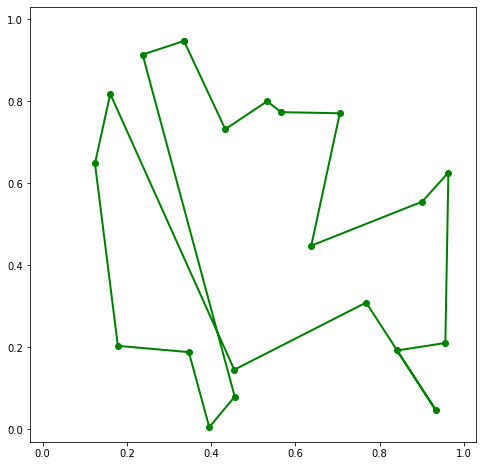

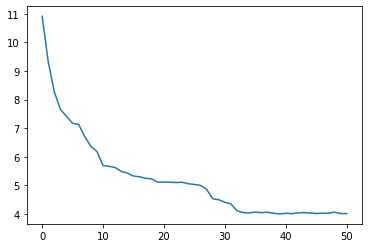

In [56]:
N = 300 # population size
t = 10 # size of tournament
p_m = 0.05 # prob of mutation
p_c = 0.05 # prob of crossover

tsp = TSP(20, seed=100) 


population, population_eval, avg_eval = evolutionary_algorithm(tsp, N, t, p_m, p_c)
arg = np.argmax(population_eval)
tsp.display_solution_param(population[arg])
plt.plot(avg_eval)

**Task 2:**

* What is the role of a mutation operator in evolutionary algorithms?
* What are the properties of a good mutation operator?
* What is the role of a crossover operator in evolutionary algorithms?
* What are the properties of a good crossover operator?
* What is the role of a cloning operator in evolutionary algorithms?
* What are the properties of a good genetic representation?
* How can you tell that the population has converged?
* How do the parameters of the evolutionary algorithm affect the speed of its convergence?
* Does the speed of the algorithm's convergence correlate with the quality of the solutions? What is the reason?
* Can a population escape from a local optimum once it has converged?


* What are the strengths of the evolutionary algorithms?
* What are the weaknesses of the evolutionary algorithms?
* What changes would you introduce to the evolutionary algorithms?
* Which problems are evolutionary algorithms best suited for?

**Task 3:** Implement the QAP (https://en.wikipedia.org/wiki/Quadratic_assignment_problem). Use EA to solve it.

In [58]:
class QAP():
    # https://arxiv.org/ftp/arxiv/papers/1405/1405.5050.pdf
    # https://www.localsolver.com/docs/last/exampletour/qap.html
    # sol[i] is the facility on the location i
    n = 0 
    distances = np.zeros((1,1))
    flows = np.zeros((1,1))
    
    def __init__(self, n, seed=1):
        # n should be grater than 2
        random.seed(seed)
        np.random.seed(seed)
        self.n = n 
        
        b = np.random.randint(0, 100, (self.n,self.n)) * 2
        np.fill_diagonal(b, 0)
        self.distances = (b + b.T)/2

        b = np.random.randint(0, 20, (self.n,self.n)) * 2
        np.fill_diagonal(b, 0)
        self.flows = (b + b.T)/2
        
    def random_solution(self):
        s = [i for i in range(self.n)]
        random.shuffle(s)        
        return s
    
    def evaluate(self, s):
        fit = np.sum([self.distances[i, j] * self.flows[s[i], s[j]] 
                      for i in range(self.n) for j in range(self.n)])     
        return fit
    
    def mutate(self, s):
        # change position of two facilities 
        sol = s[:]
        pos = random.sample(range(0, self.n), 2)
        temp = sol[pos[0]]
        sol[pos[0]] = sol[pos[1]]
        sol[pos[1]] = temp
        return sol
    
    def _increment_i(self, i, fixed_pos):
        if i + 1 in fixed_pos and i + 2 in fixed_pos:
            return i + 3
        elif i + 1 in fixed_pos:
            return i + 2
        else:
            return i + 1
    
    def _create_child(self, parent1, parent2, fixed_pos):
        # parent1 - fixed positions are the same, the rest is from parent 2
        child = [-1 for i in range(self.n)]
        fixed_val = [parent1[fixed_pos[0]], parent1[fixed_pos[1]]]
        child[fixed_pos[0]], child[fixed_pos[1]] = parent1[fixed_pos[0]], parent1[fixed_pos[1]]
        
        p1_i = self._increment_i(-1, fixed_pos)
            
        for p2_i in range(self.n):
            val = parent2[p2_i] 
            if val not in fixed_val:
                child[p1_i] = val
                p1_i = self._increment_i(p1_i, fixed_pos)

        return child
        
    
    def crossover(self, s1, s2):
        sol1, sol2 = s1[:], s2[:]
        fixed_pos = random.sample(range(0, self.n), 2)
        sol1 = self._create_child(s1, s2, fixed_pos)
        sol2 = self._create_child(s2, s1, fixed_pos)
        return sol1, sol2

[399006.89, 392344.79, 387136.68, 384104.27, 382352.51, 380387.14, 379423.41, 379288.61, 379369.41, 378618.47, 378774.32, 378948.71, 378913.22, 378635.08, 377722.38, 377072.82, 375118.83, 374048.33, 373797.73, 373868.28, 373779.01, 373713.21, 373118.51, 372600.19, 372371.68, 371861.12, 371492.33, 371422.04, 371336.37, 371051.72, 370460.47, 370016.58, 370109.48, 369739.92, 369828.66, 369748.72, 369844.73, 369414.14, 369307.29, 369585.34, 369855.99, 369709.31, 369464.31, 369157.69, 367954.51, 365414.49, 363117.28, 363083.89, 363278.88, 363338.98, 363641.5]


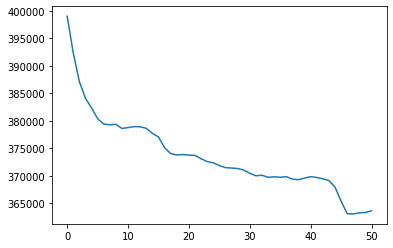

In [67]:
qap = QAP(15)
population, population_eval, avg_eval = evolutionary_algorithm(qap, N, t, p_m, p_c)
print(avg_eval)
plt.plot(avg_eval)

**Task 4:** Choose one of the problems (TSP or QAP). Assume a constant number of fitness evaluations per each evolutionary run. For a sufficiently big (nontrivial) problem:

a) Assume $N = 200$, $t = 5$. Prepare a heatmap illustrating the influence of values of $p_m$ and $p_c$ on the quality of the solution.

b) Assume $p_m = 0.5$, $p_c = 0.5$. Prepare a heatmap illustrating the influence of values of $N$ and $t$ on the quality of the solution.

Discuss the results. Can we expect to see similar results under different search termination conditions (e.g. a number of iterations with no improvement)? Can we expect to see similar results for different optimization problems?

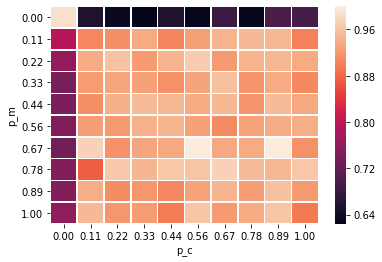

In [100]:
N = 200
t = 5
size = 10

evals = np.zeros(shape=(size, size ))
for p_m_ in range(size):
    for p_c_ in range(size):
#         print(p_m_/(size - 1))
        tsp = TSP(20, seed=100) 
        population, population_eval, avg_eval = evolutionary_algorithm(tsp, N, t, p_m_, p_c_)
        evals[p_m_, p_c_] = avg_eval[-1]

        
evals = evals / np.max(evals)
tick_label = [f"{i / (size - 1):.2f}" for i in range(size)]
ax = sns.heatmap(evals, linewidth=0.5, xticklabels=tick_label, yticklabels=tick_label)
plt.xlabel("p_c")
plt.ylabel("p_m")
plt.show()

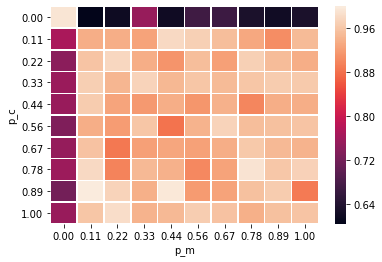

In [98]:
N = 200
t = 5
size = 10

evals = np.zeros(shape=(size, size ))
for p_m_ in range(size):
    for p_c_ in range(size):
#         print(p_m_/(size - 1))
        tsp = TSP(20, seed=100) 
        population, population_eval, avg_eval = evolutionary_algorithm(tsp, N, t, p_m_, p_c_)
        evals[p_m_, p_c_] = avg_eval[-1]

        
evals = evals / np.max(evals)
tick_label_x = [f"{i / (size - 1):.2f}" for i in range(size)]
tick_label_y = [f"{i / (size - 1):.2f}" for i in range(size)]
ax = sns.heatmap(evals, linewidth=0.5, xticklabels=tick_label, yticklabels=tick_label)
plt.xlabel("p_m")
plt.ylabel("p_c")
plt.show() = 200
t = 5
size = 10

evals = np.zeros(shape=(size, size ))
for p_m_ in range(size):
    for p_c_ in range(size):
#         print(p_m_/(size - 1))
        tsp = TSP(20, seed=100) 
        population, population_eval, avg_eval = evolutionary_algorithm(tsp, N, t, p_m_, p_c_)
        evals[p_m_, p_c_] = avg_eval[-1]

        
evals = evals / np.max(evals)
tick_label = [f"{i / (size - 1):.2f}" for i in range(size)]
ax = sns.heatmap(evals, linewidth=0.5, xticklabels=tick_label, yticklabels=tick_label)
plt.xlabel("p_m")
plt.ylabel("p_c")
plt.show()